In [ ]:
import math
import torch
import shutil
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import get_cosine_schedule_with_warmup
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### $\text {Making Dataset class}$

In [ ]:
class ReverseDataset(Dataset):
    def __init__(self, vocab_size, seq_len, size):
        super().__init__()
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(3, self.vocab_size, size=(self.size,
                                                            self.seq_len - 2))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))

        inp_data = torch.Tensor(
            [1] + inp_data.tolist() + [2]
        ).type("torch.LongTensor")
        labels = torch.Tensor(
            [1] + labels.tolist() + [2]
        ).type("torch.LongTensor")

        return inp_data, labels

In [ ]:
MAX_SEQ_LEN = 10
vocab_size = 2048
train_data_size = 50000
test_data_size = 12
emb_size = 512
n_heads = 8
num_layers = 6
scaling_factor = 4
dropout_p = 0.1
epochs = 5

In [ ]:
train_data = ReverseDataset(vocab_size=vocab_size,
                            seq_len=MAX_SEQ_LEN,
                            size=train_data_size)

In [ ]:
test_data = ReverseDataset(vocab_size=vocab_size,
                            seq_len=MAX_SEQ_LEN,
                            size=test_data_size)

In [ ]:
train_loader = DataLoader(train_data, 128, shuffle=True)
test_loader = DataLoader(test_data, 128, shuffle=True)

### $\text {Firstly we need to make embeddings of our tokens. Let`s make Embeddings class for this}$

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(Embeddings, self).__init__()

        self.vocab_size = vocab_size
        self.emb_size = emb_size

        self.emb = nn.Embedding(self.vocab_size, self.emb_size)

    def forward(self, X):
        emb = self.emb(X)

        return emb # size = [batch_size*seq_len*emb_size]

### $\text{Next, in transformer we use Positional Encoding, since transformer doesn`t} \\ \text{take into account the position of words}$

### $$\text{PE}_{(pos, 2i)} = \sin \left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right)$$

### $$\text{PE}_{(pos, 2i + 1)} = \cos \left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)$$

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, seq_len, emb_size=512):
        super(PositionalEncoding, self).__init__()

        self.seq_len = seq_len
        self.emb_size = emb_size

        pe = torch.zeros(size=(self.seq_len, self.emb_size))

        for position in range(self.seq_len):
            for i in range(0, self.emb_size, 2):
                pe[position, i] = math.sin(position/10000**(2*i/self.emb_size))
                if i + 1 < self.emb_size:
                    pe[position, i + 1] = math.cos(position/10000**(2*i/self.emb_size))

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, X):

        X = X * math.sqrt(self.emb_size)

        current_seq_len = X.size(1)
        pe = self.pe[:, :current_seq_len].to(device)  # [1, current_seq_len, emb_size]

        X = X + pe

        return X


### $\text{Let`s create a Sublayer class, that will be responsible} \\ \text{for residual connection and layer normalization}$

In [ ]:
class Sublayer(nn.Module):
    def __init__(self, emb_size=512, dropout_p=0.2):
        super(Sublayer, self).__init__()
        """
        param emb_size: size of model
        param dropout_p: probability of dropout

        """
        self.norm = nn.LayerNorm(emb_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, X, result):
        """
        param X: input data
        param result: x which we passed through some function

        """
        out = X + self.dropout(self.norm(result))

        return out

### $\text {FFN class}$

### $$\text{FFN}(x) = \max(0, xW_{1} + b_{1})W_{2} + b_{2}$$

In [ ]:
class FFN(nn.Module):
    def __init__(self, emb_size=512, scaling_factor=4, dropout_p=0.2):
        super(FFN, self).__init__()

        """
        param emb_size: size of model
        param scaling_factor: scaling_factor*emb_size = size of hidden layer
        param dropout_p: probability of dropout

        """

        self.linear = nn.Sequential(
            nn.Linear(emb_size, emb_size*scaling_factor),
            nn.ReLU(),
            nn.Linear(emb_size*scaling_factor, emb_size)
        )

        self.dropout = nn.Dropout(dropout_p)

    def forward(self, X):

        out = self.dropout(self.linear(X))

        return out

### $\text {Next, we need to realize the main idea of transformer`s model - Multihead Attention}$

### $$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^{T}}{\sqrt{d_\text{model}}}\right)V$$

In [ ]:
class MultiheadAttention(nn.Module):
    def __init__(self, emb_size=512, n_heads=8):
        super(MultiheadAttention, self).__init__()

        self.emb_size = emb_size
        self.n_heads = n_heads

        self.single_head_dim = int(self.emb_size / self.n_heads)

        self.k_matrix = nn.Linear(self.single_head_dim, self.single_head_dim)
        self.q_matrix = nn.Linear(self.single_head_dim, self.single_head_dim)
        self.v_matrix = nn.Linear(self.single_head_dim, self.single_head_dim)

        self.out = nn.Linear(self.n_heads * self.single_head_dim, self.emb_size)

        self.att_weights = None

    def forward(self, query, key, value, mask=None):
        """
        key, query, value - same embeddings, after nn.Embedding layer in encoder

        key.shape=value.shape!=query.shape in decoder

        """

        batch_size = key.shape[0]
        seq_len = key.shape[1]

        # for decoder we use another length for query as the length will be different
        query_len = query.shape[1]

        # divide into 8 heads
        query = query.view(batch_size, query_len, self.n_heads, self.single_head_dim)
        key = key.view(batch_size, seq_len, self.n_heads, self.single_head_dim)
        value = value.view(batch_size, seq_len, self.n_heads, self.single_head_dim)

        k = self.k_matrix(key)
        q = self.q_matrix(query)
        v = self.v_matrix(value)

        # transpose matrix for better multiplication in Pytorch

        q = q.transpose(1, 2) #[batch_size*n_heads*query_len*single_head_dim]
        k = k.transpose(1, 2) #[batch_size*n_heads*seq_len*single_head_dim]
        v = v.transpose(1, 2) #[batch_size*n_heads*seq_len*single_head_dim]

        product = torch.matmul(q, k.transpose(2, 3))

        # scaling
        product = product / math.sqrt(self.single_head_dim)

        # for case in which we have mask

        if mask is not None:
            product = product.masked_fill(mask == 0, float('-inf'))

        att_weights = torch.softmax(product, dim=-1)
        self.att_weights = att_weights

        scores = torch.matmul(att_weights, v) # [batch_size*n_heads*seq_len*single_head_dim]

        concat = scores.transpose(1, 2).contiguous().view(batch_size,
                                                          query_len,
                                                          self.n_heads *
                                                          self.single_head_dim)

        # print(concat.shape)
        output = self.out(concat) # [batch_size*seq_len*emb_dim]

        return output

### $\text {Encoder structure}$

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, emb_size=512, dropout_p=0.2, scaling_factor=4, n_heads=8):
        super(EncoderBlock, self).__init__()

        self.att = MultiheadAttention(emb_size, n_heads)
        self.sublayer = Sublayer(emb_size, dropout_p)
        self.ffn = FFN(emb_size, scaling_factor)

    def forward(self, X, src_mask):
        out = self.sublayer(X, self.att(X, X, X, src_mask))
        out = self.sublayer(out, self.ffn(out))

        return out


In [ ]:
class Encoder(nn.Module):
    def __init__(self,
                 seq_len,
                 vocab_size,
                 emb_size=512,
                 dropout_p=0.2,
                 scaling_factor=4,
                 n_heads=8,
                 num_layers=6):
        super(Encoder, self).__init__()

        self.emb = Embeddings(vocab_size, emb_size)
        self.pe = PositionalEncoding(seq_len, emb_size)
        self.enc_layers = nn.ModuleList([
            EncoderBlock(emb_size, dropout_p, scaling_factor, n_heads)
            for _ in range(num_layers)
        ])

    def forward(self, X, mask):
        embeded = self.emb(X)
        out = self.pe(embeded)

        for layer in self.enc_layers:
            out = layer(out, mask)

        return out

### $\text{Decoder structure}$

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, emb_size=512, dropout_p=0.2, scaling_factor=4, n_heads=8):
        super(DecoderBlock, self).__init__()

        self.mask_att = MultiheadAttention(emb_size, n_heads)
        self.cross_att = MultiheadAttention(emb_size, n_heads)
        self.ffn = FFN(emb_size, scaling_factor, dropout_p)
        self.sublayer = Sublayer(emb_size, dropout_p)

    def forward(self, X, enc_out, src_mask, trg_mask):
        """
        param X: target sequence
        param enc_out: out from encoder
        param src_mask: mask for src, that hide pad_tokens
        param trg_mask: mask for target, to hide 'future' tokens

        """

        out = self.sublayer(X, self.mask_att(X,
                                             X,
                                             X,
                                             mask=trg_mask))
        out = self.sublayer(out, self.cross_att(out,
                                                enc_out,
                                                enc_out,
                                                mask=src_mask))
        out = self.sublayer(out, self.ffn(out))

        return out


### $\text
{In my case I use CrossEntropyLoss, since I don`t use Softmax after fully connected layer in final step}$

In [ ]:
class Decoder(nn.Module):
    def __init__(self,
                 seq_len,
                 vocab_size,
                 emb_size=512,
                 dropout_p=0.2,
                 scaling_factor=4,
                 n_heads=8,
                 num_layers=6):
        super(Decoder, self).__init__()

        self.emb = Embeddings(vocab_size, emb_size)
        self.pe = PositionalEncoding(seq_len, emb_size)
        self.dec_layers = nn.ModuleList([DecoderBlock(emb_size, dropout_p, scaling_factor, n_heads)
                                     for _ in range(num_layers)])

        self.out = nn.Sequential(
            nn.Linear(emb_size, vocab_size),
            # nn.Softmax(dim=-1) don`t use in my implementation
        )

    def forward(self, X, enc_out, src_mask, trg_mask):
        embeded = self.emb(X)
        out = self.pe(embeded)

        for layer in self.dec_layers:
            out = layer(out, enc_out, src_mask, trg_mask)

        out = self.out(out)

        return out

In [ ]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super(Transformer, self).__init__()

        self.enc = encoder
        self.dec = decoder

    def encode(self, src, src_mask):
        return self.enc(src, src_mask)

    def decode(self, trg, enc_out, src_mask, trg_mask):
        return self.dec(trg, enc_out, src_mask, trg_mask)

    def forward(self, src, trg, src_mask, trg_mask):
        enc_out = self.encode(src, src_mask)
        return self.decode(trg, enc_out, src_mask, trg_mask)

### $\text{Making function for creating all maskes}$

In [ ]:
def create_mask(src, trg):
    """
    Create masks for source and target sequences.

    Args:
        src (torch.Tensor): Source sequence tensor of shape [batch_size, src_seq_len].
        trg (torch.Tensor): Target sequence tensor of shape [batch_size, trg_seq_len].

    Returns:
        src_mask (torch.Tensor): Mask for source sequence of shape [batch_size, 1, 1, src_seq_len].
        trg_mask (torch.Tensor): Mask for target sequence of shape [batch_size, 1, trg_seq_len, trg_seq_len].
    """

    src_mask = (src != 0).unsqueeze(1).unsqueeze(2)  # [batch_size, 1, 1, src_seq_len]

    trg_seq_len = trg.shape[1]
    trg_padding_mask = (trg != 0).unsqueeze(1).unsqueeze(2)  # [batch_size, 1, 1, trg_seq_len]
    trg_subsequent_mask = torch.tril(torch.ones(trg_seq_len,
                                                trg_seq_len)).type_as(src_mask)  # [trg_seq_len, trg_seq_len]
    trg_mask = trg_padding_mask & trg_subsequent_mask.unsqueeze(0)  # [batch_size, 1, trg_seq_len, trg_seq_len]

    return src_mask, trg_mask

### $\text{Example of working}$

In [ ]:
X, y = next(iter(train_loader))
X.shape, y.shape

(torch.Size([128, 10]), torch.Size([128, 10]))

In [ ]:
src_mask, trg_mask = create_mask(X, y)

In [ ]:
src_mask.shape, trg_mask.shape

(torch.Size([128, 1, 1, 10]), torch.Size([128, 1, 10, 10]))

### $\text{Create model}$

In [ ]:
enc = Encoder(MAX_SEQ_LEN,
                  vocab_size,
                  emb_size,
                  dropout_p,
                  scaling_factor,
                  n_heads,
                  num_layers).to(device)

dec = Decoder(MAX_SEQ_LEN,
              vocab_size,
              emb_size,
              dropout_p,
              scaling_factor,
              n_heads,
              num_layers).to(device)

model = Transformer(enc, dec).to(device)
model

Transformer(
  (enc): Encoder(
    (emb): Embeddings(
      (emb): Embedding(2048, 512)
    )
    (pe): PositionalEncoding()
    (enc_layers): ModuleList(
      (0-5): 6 x EncoderBlock(
        (att): MultiheadAttention(
          (k_matrix): Linear(in_features=64, out_features=64, bias=True)
          (q_matrix): Linear(in_features=64, out_features=64, bias=True)
          (v_matrix): Linear(in_features=64, out_features=64, bias=True)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (sublayer): Sublayer(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ffn): FFN(
          (linear): Sequential(
            (0): Linear(in_features=512, out_features=2048, bias=True)
            (1): ReLU()
            (2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (dec):

### $\text{Initialize weights}$

In [ ]:
def intialize_weights(model):
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

In [ ]:
intialize_weights(model)

### $\text{Training process}$

In [ ]:
num_training_steps = epochs * len(train_loader)
num_warmup_steps = int(0.1*num_training_steps)
print(f'num_training_steps = {num_training_steps}, \nnum_warmup_steps = {num_warmup_steps}')

num_training_steps = 1955, 
num_warmup_steps = 195


In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

sheduler = get_cosine_schedule_with_warmup(optimizer=optimizer,
                                           num_warmup_steps=num_warmup_steps,
                                           num_training_steps=num_training_steps)

In [ ]:
model.train()
epoch_losses = []

for epoch in range(epochs):
    batch_loss = []
    for X_batch, y_batch in tqdm(train_loader):

        dec_inp = y_batch[:, :-1]
        dec_trg = y_batch[:, 1:].to(device)

        src_mask, trg_mask = create_mask(X_batch, dec_inp)
        # print(f'src_mask = {src_mask}, src_mask shape = {src_mask.shape}')
        # print(f'trg_mask = {trg_mask}, trg_mask shape = {trg_mask.shape}')

        src = X_batch.to(device)
        # print(f'src: {src}')
        # print(f'target: {trg}')

        optimizer.zero_grad()
        out = model(src,
                    dec_inp.to(device),
                    src_mask.to(device),
                    trg_mask.to(device))

        loss = criterion(out.view(-1, vocab_size),
                         dec_trg.view(-1))

        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        sheduler.step()

        batch_loss.append(loss.item())

    epoch_losses.append(np.mean(batch_loss))
    print(f'loss = {np.mean(batch_loss)}')


100%|██████████| 391/391 [00:40<00:00,  9.68it/s]


loss = 5.887939529345774


100%|██████████| 391/391 [00:41<00:00,  9.46it/s]


loss = 2.9805644009729177


100%|██████████| 391/391 [00:42<00:00,  9.14it/s]


loss = 0.5745479321140615


100%|██████████| 391/391 [00:41<00:00,  9.32it/s]


loss = 0.023738124384902075


100%|██████████| 391/391 [00:42<00:00,  9.21it/s]

loss = 0.0028287555806992618


In [ ]:
path = 'transformer_weights.pth'
torch.save(model.state_dict(), path)

gdrive_path = '/content/drive/MyDrive/transformer_weights.pth'

shutil.move(path, gdrive_path)
print(f"Weights uploaded to Google Drive: {gdrive_path}")

Weights uploaded to Google Drive: /content/drive/MyDrive/transformer_weights.pth


### $\text {Create function for inference}$

In [ ]:
def inference(model, src, max_len=10, start_token=1, end_token=2):
    """
    Perform inference using the Transformer model.

    Args:
        model (nn.Module): The Transformer model.
        src (torch.Tensor): Source sequence tensor of shape [1, src_seq_len].
        max_len (int): Maximum length of the generated sequence. Default is 10.
        start_token (int): Token indicating the start of the sequence. Default is 1.
        end_token (int): Token indicating the end of the sequence. Default is 2.

    Returns:
        torch.Tensor: Generated sequence tensor of shape [1, generated_seq_len].
    """
    model.eval()

    # Создаем маску для исходной последовательности
    src_mask = (src != 0).unsqueeze(1).unsqueeze(2)  # [1, 1, 1, src_seq_len]

    # Перемещаем данные на устройство модели
    src = src.to(device)
    src_mask = src_mask.to(device)

    with torch.no_grad():
        enc_out = model.encode(src, src_mask)  # [1, src_seq_len, emb_size]

    trg = torch.ones(1, 1).fill_(start_token).type_as(src)  # [1, 1]

    for _ in range(max_len - 1):
        trg_seq_len = trg.size(1)  # Текущая длина целевой последовательности
        trg_mask = torch.tril(torch.ones(trg_seq_len, trg_seq_len)).type_as(src_mask)  # [trg_seq_len, trg_seq_len]
        trg_mask = trg_mask.unsqueeze(0).unsqueeze(0)  # [1, 1, trg_seq_len, trg_seq_len]

        trg = trg.to(device)
        trg_mask = trg_mask.to(device)

        with torch.no_grad():
            out = model.decode(trg, enc_out, src_mask, trg_mask)  # [1, trg_seq_len, vocab_size]

        out = out.softmax(dim=-1)
        next_token = out.argmax(dim=-1)[:, -1].unsqueeze(1)  # [1, 1]
        trg = torch.cat([trg, next_token], dim=1)

        if next_token.item() == end_token:
            break

    return trg

### $\text{Let`s reverse some sequence}$

In [ ]:
# Import weights for model
gdrive_path = '/content/drive/MyDrive/transformer_weights.pth'

model.load_state_dict(torch.load(gdrive_path, map_location=torch.device('cpu')))
model.to(device)

Transformer(
  (enc): Encoder(
    (emb): Embeddings(
      (emb): Embedding(2048, 512)
    )
    (pe): PositionalEncoding()
    (enc_layers): ModuleList(
      (0-5): 6 x EncoderBlock(
        (att): MultiheadAttention(
          (k_matrix): Linear(in_features=64, out_features=64, bias=True)
          (q_matrix): Linear(in_features=64, out_features=64, bias=True)
          (v_matrix): Linear(in_features=64, out_features=64, bias=True)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (sublayer): Sublayer(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ffn): FFN(
          (linear): Sequential(
            (0): Linear(in_features=512, out_features=2048, bias=True)
            (1): ReLU()
            (2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (dec):

In [ ]:

input_sequence = [1, 474, 1209, 1105, 1075, 436, 1227, 1670, 1358, 2]
src = torch.tensor([input_sequence])

# Прогоняем через модель
predicted_sequence = inference(model, src)

# Преобразуем результат в читаемый формат
predicted_sequence = predicted_sequence.squeeze(0).cpu().numpy().tolist()
print("Input sequence:", input_sequence)
print("Predicted sequence:", predicted_sequence)

Input sequence: [1, 474, 1209, 1105, 1075, 436, 1227, 1670, 1358, 2]
Predicted sequence: [1, 1358, 1670, 1227, 436, 1075, 1105, 1209, 474, 2]


### $\text{Let`s show attention maps for encoder layers}$

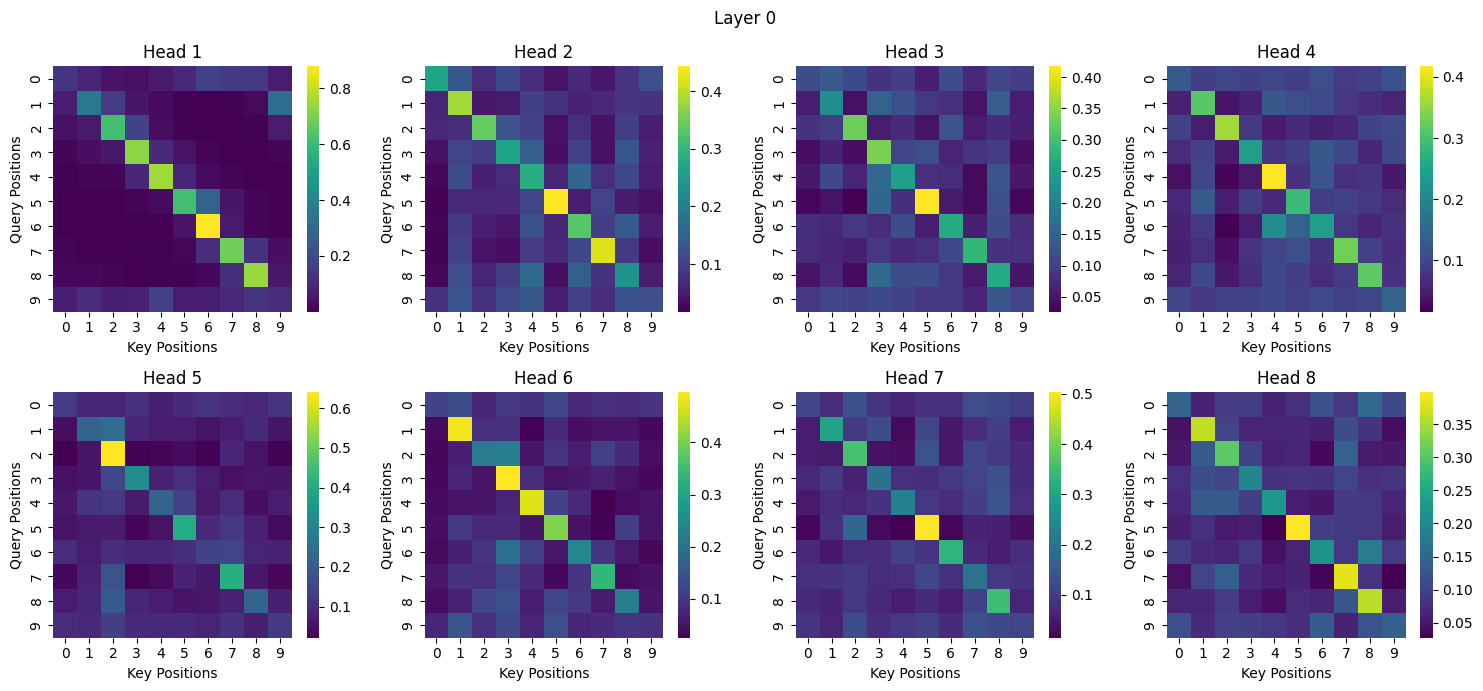

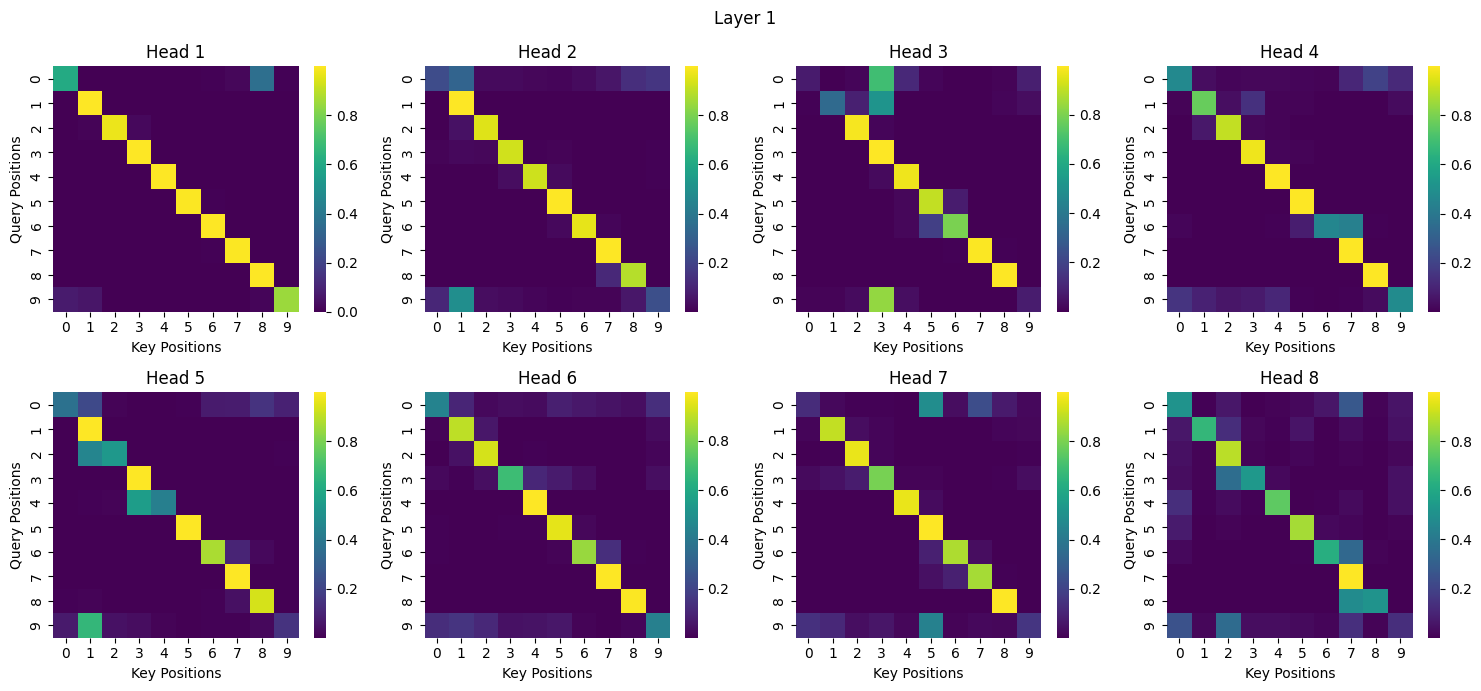

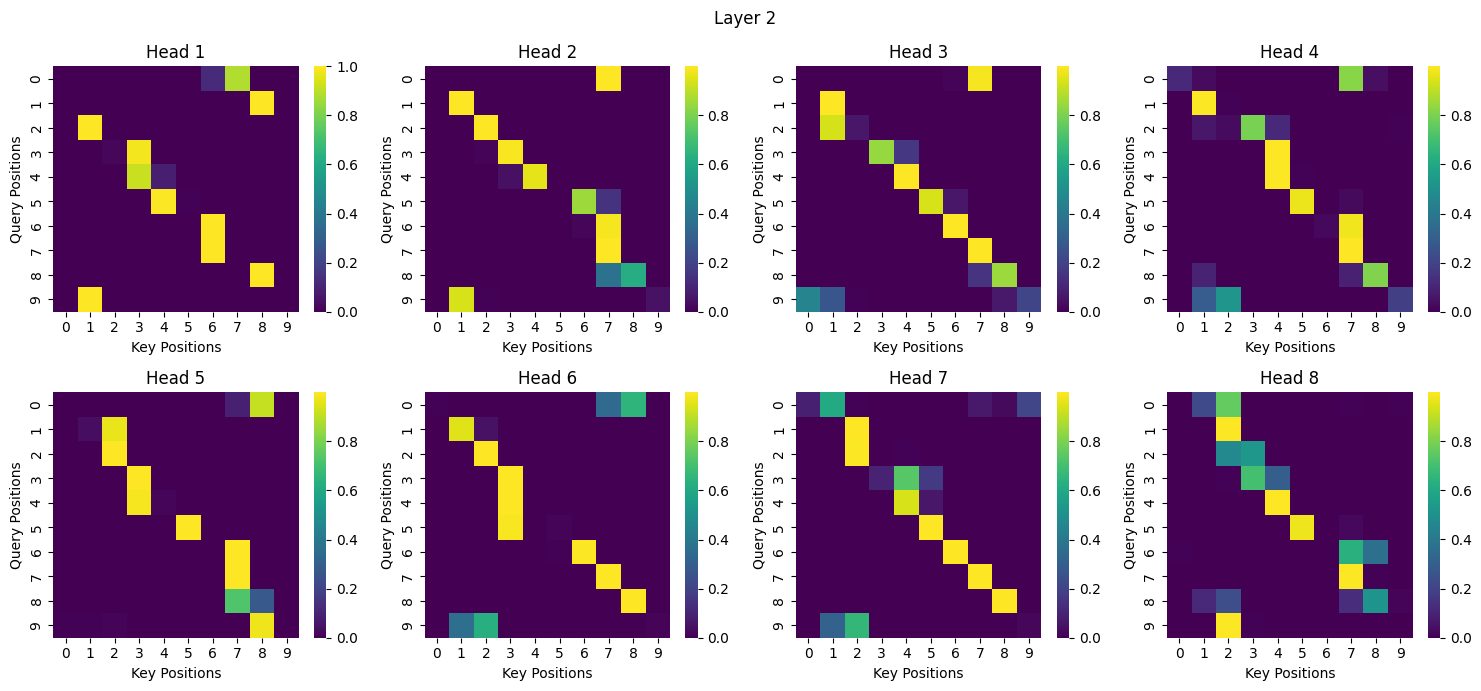

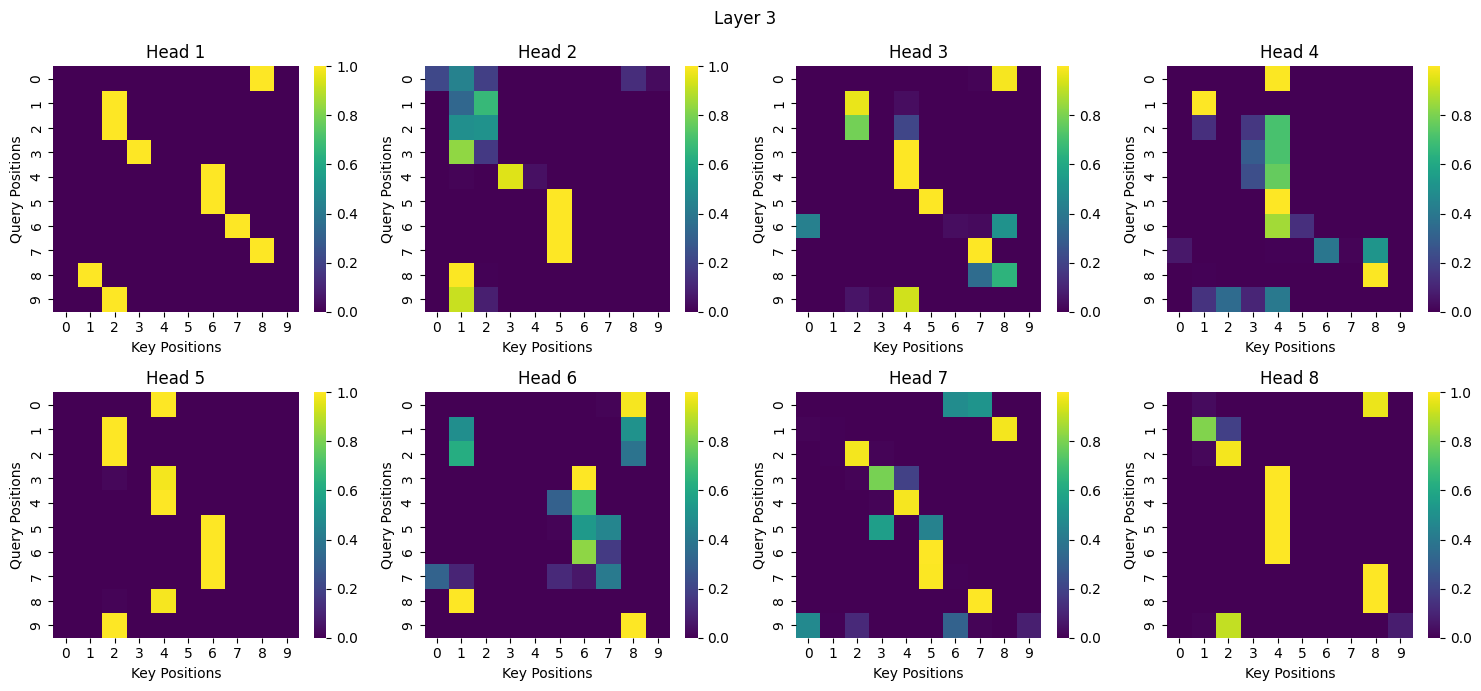

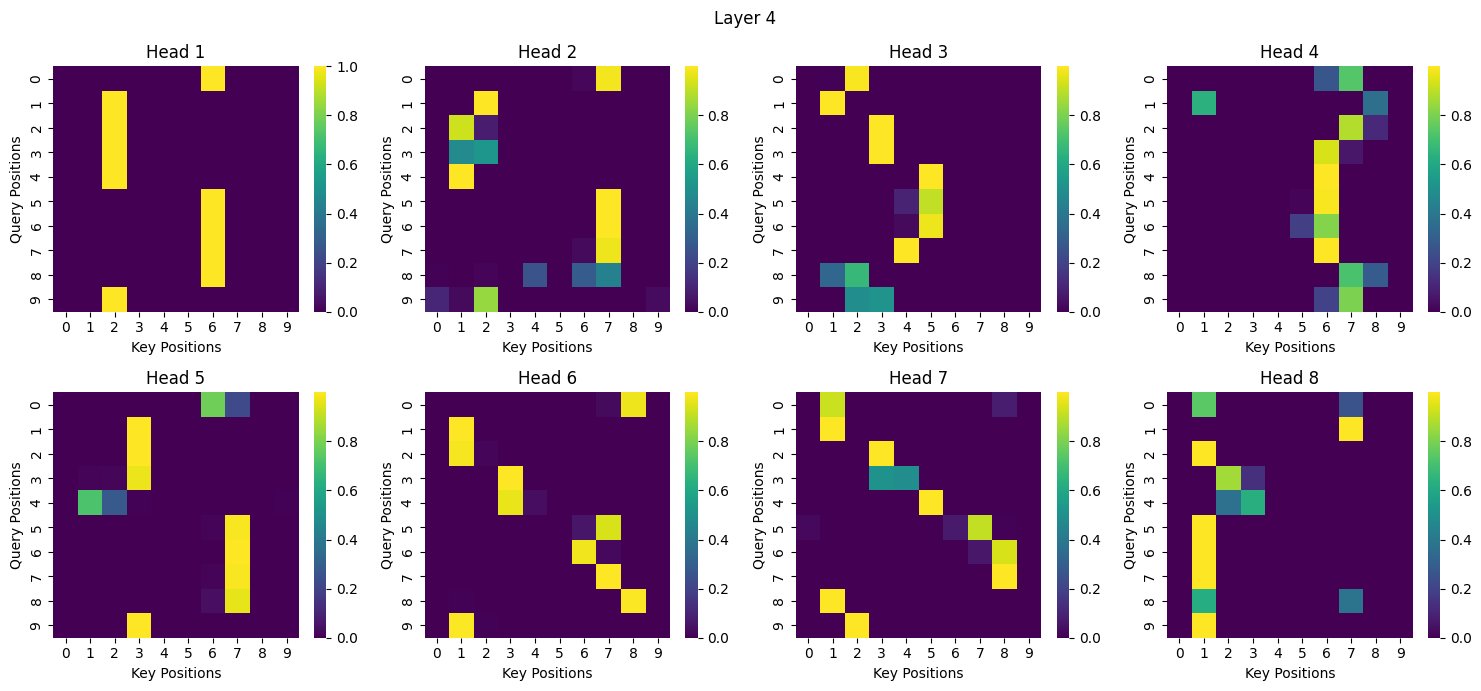

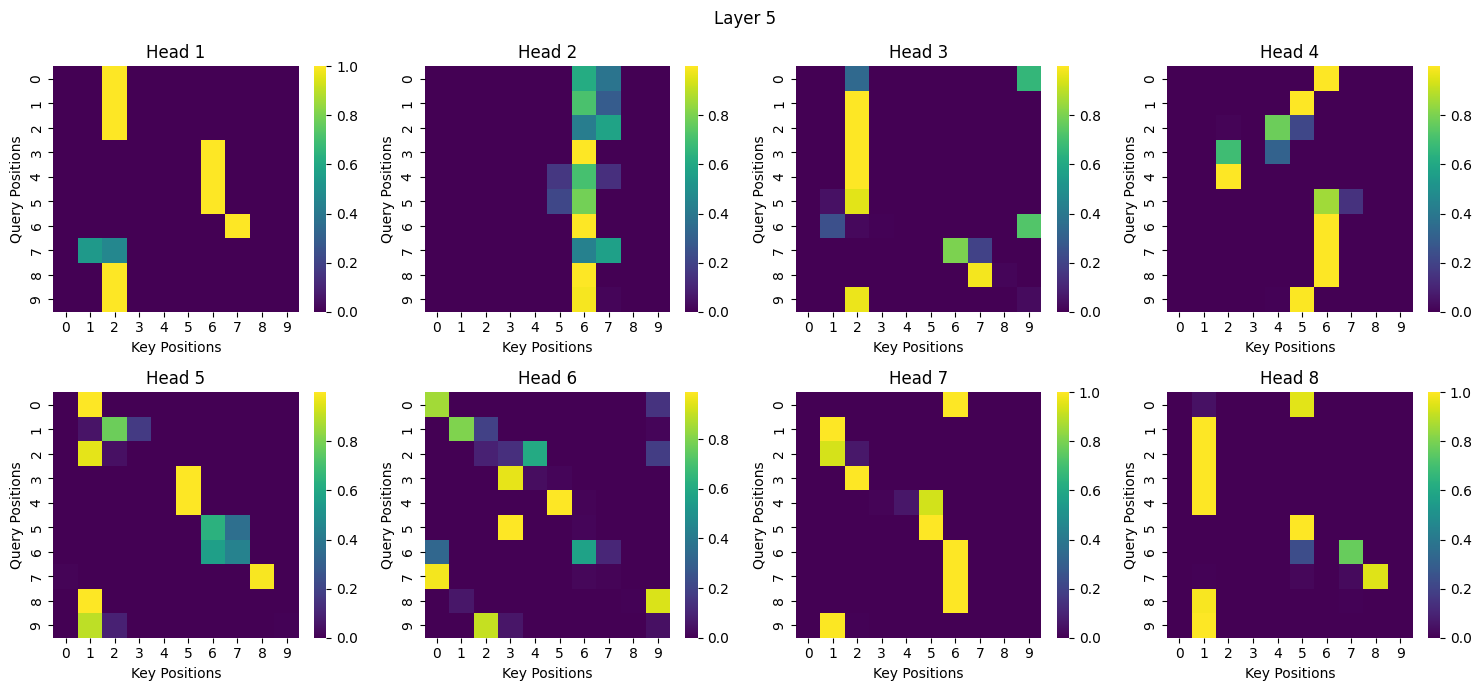

In [ ]:
for num, layer in enumerate(model.enc.enc_layers):
    att_maps = layer.att.att_weights[0].detach().cpu().numpy()

    n_heads = att_maps.shape[0]

    fig, ax = plt.subplots(2, n_heads // 2, figsize=(15, 7))

    for i in range(n_heads):
        row = i // (n_heads // 2)  # Определяем строку
        col = i % (n_heads // 2)   # Определяем столбец
        sns.heatmap(att_maps[i],
                    ax=ax[row, col],
                    cmap="viridis")
        ax[row, col].set_title(f"Head {i + 1}")
        ax[row, col].set_xlabel("Key Positions")
        ax[row, col].set_ylabel("Query Positions")

    fig.suptitle(f'Layer {num}')
    plt.tight_layout()
    plt.show()

### $\text{Let`s show attention maps for masked self-attention in decoder
layers}$

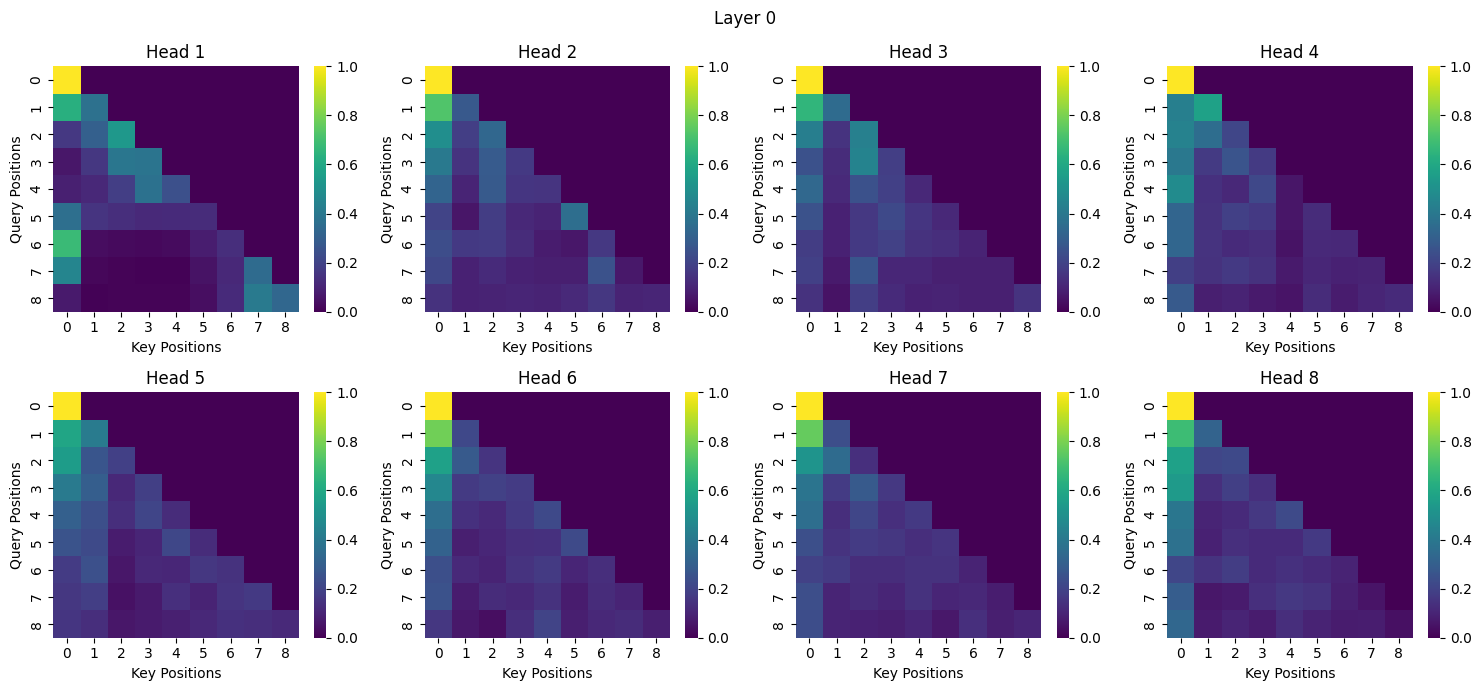

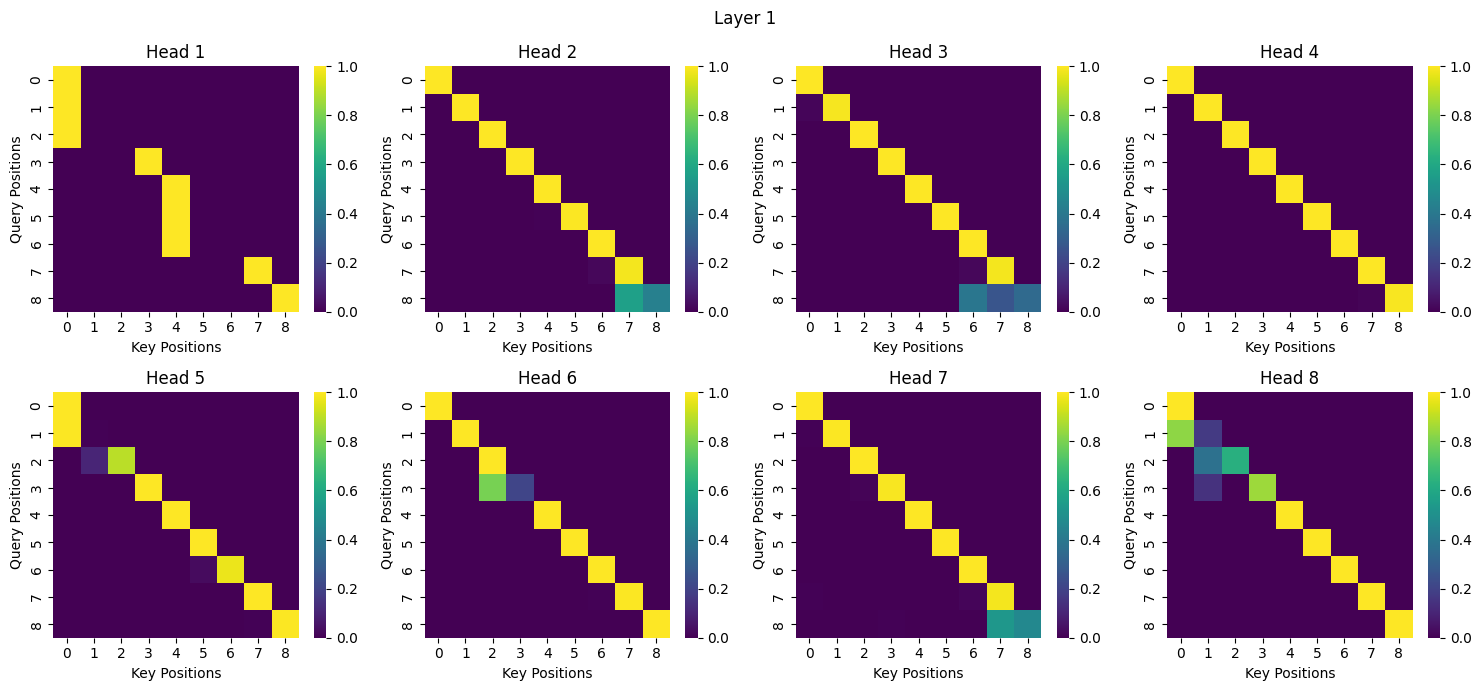

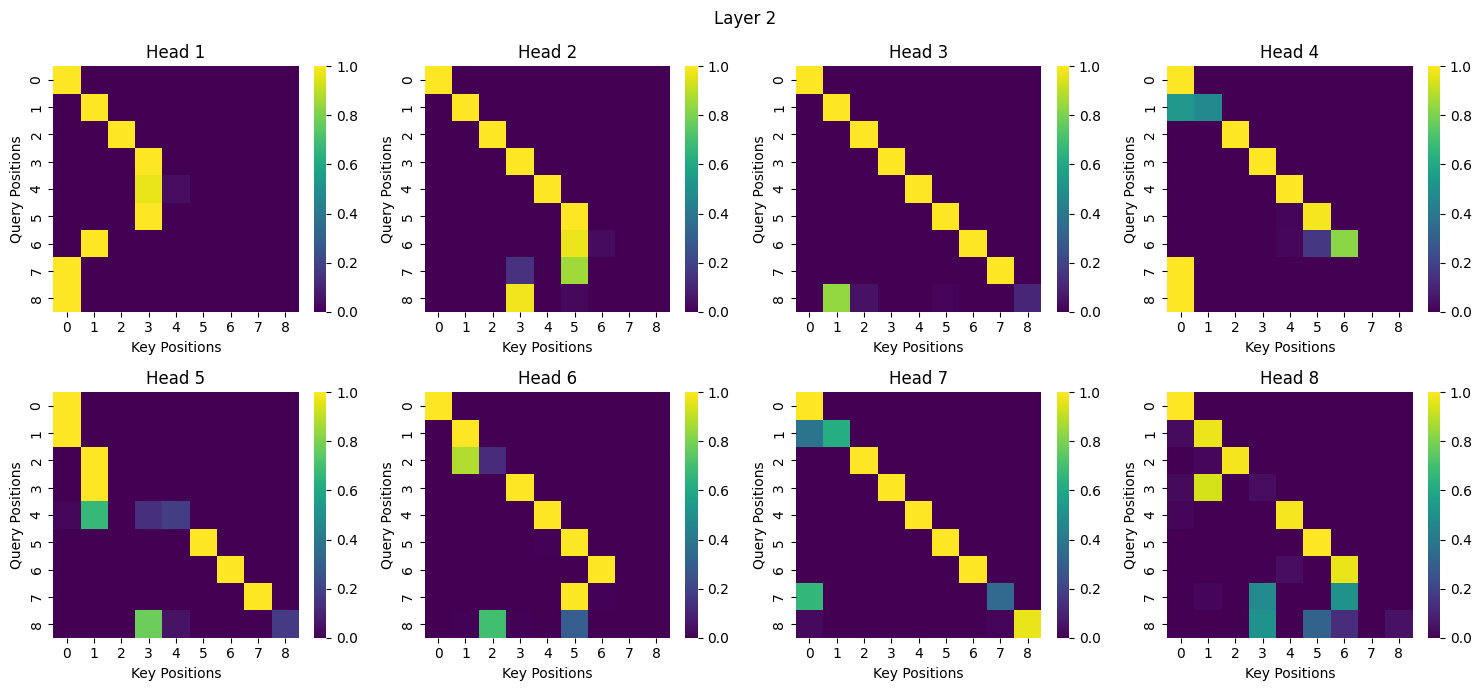

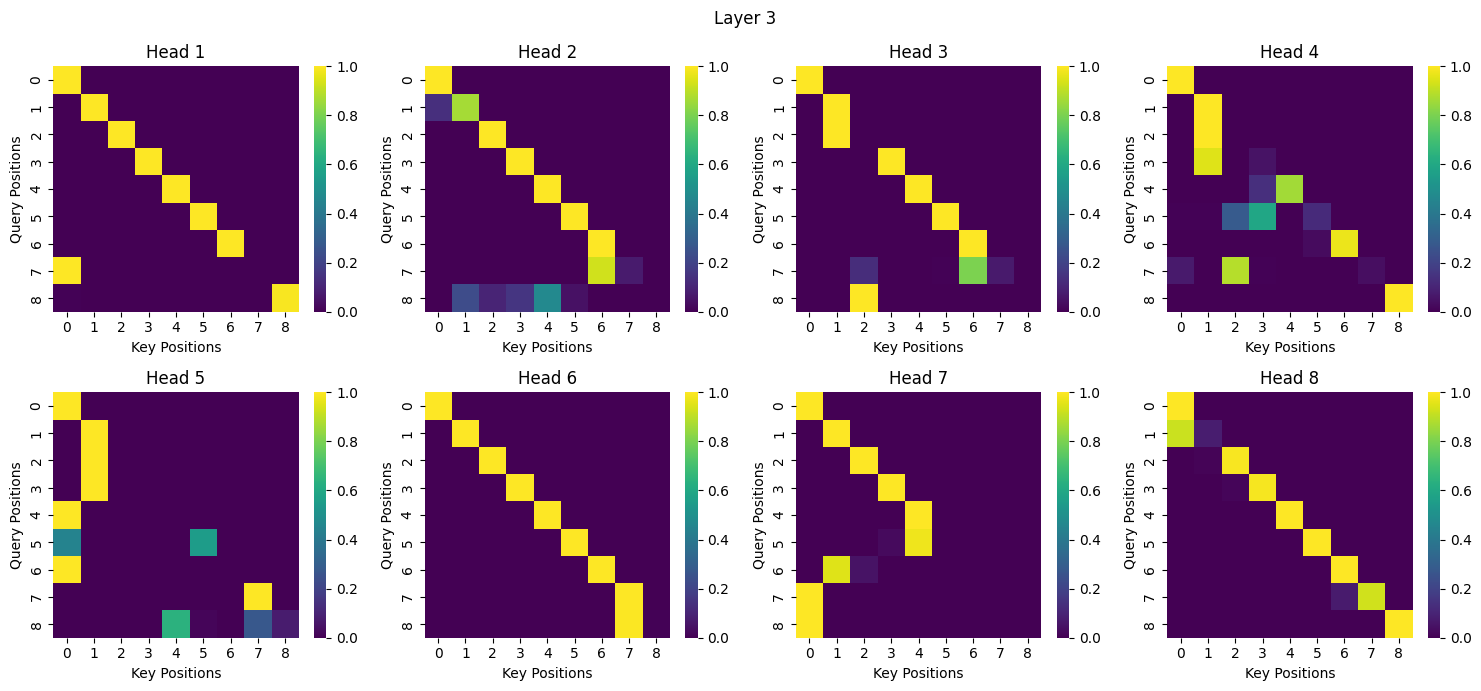

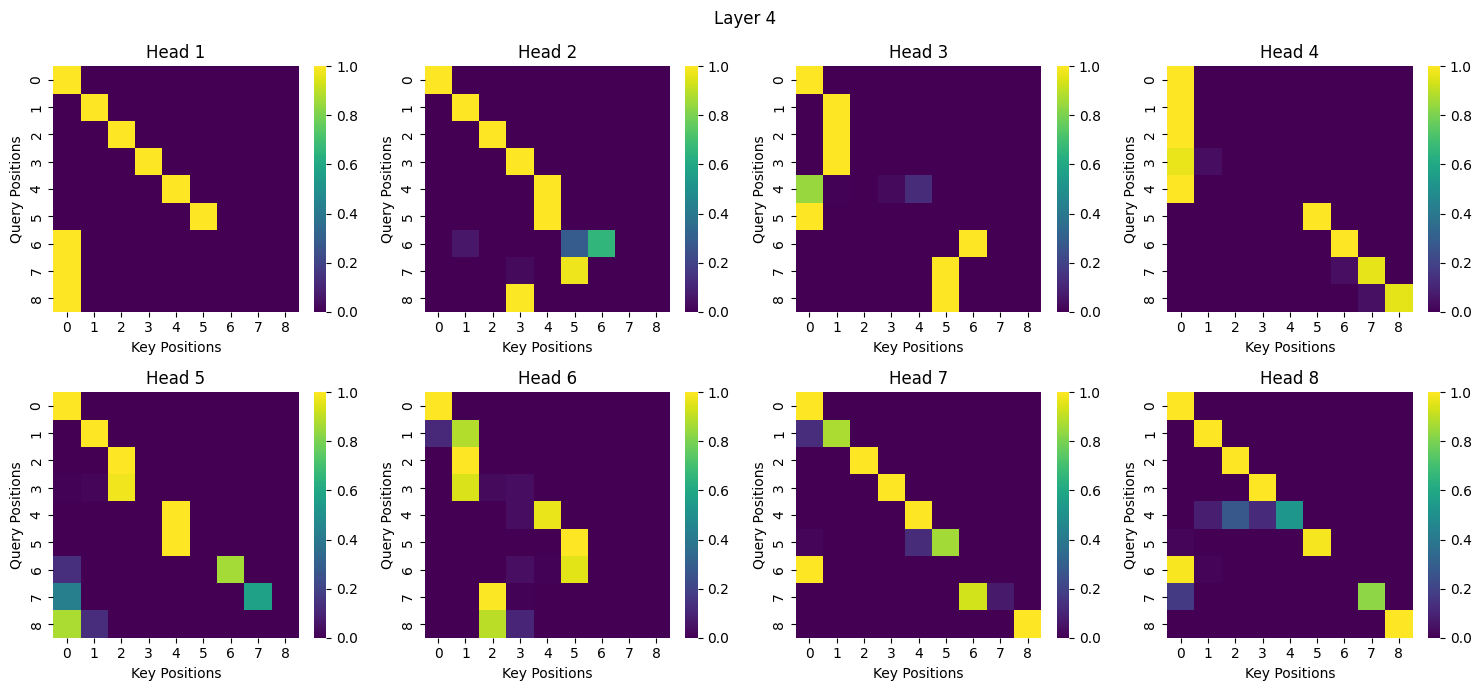

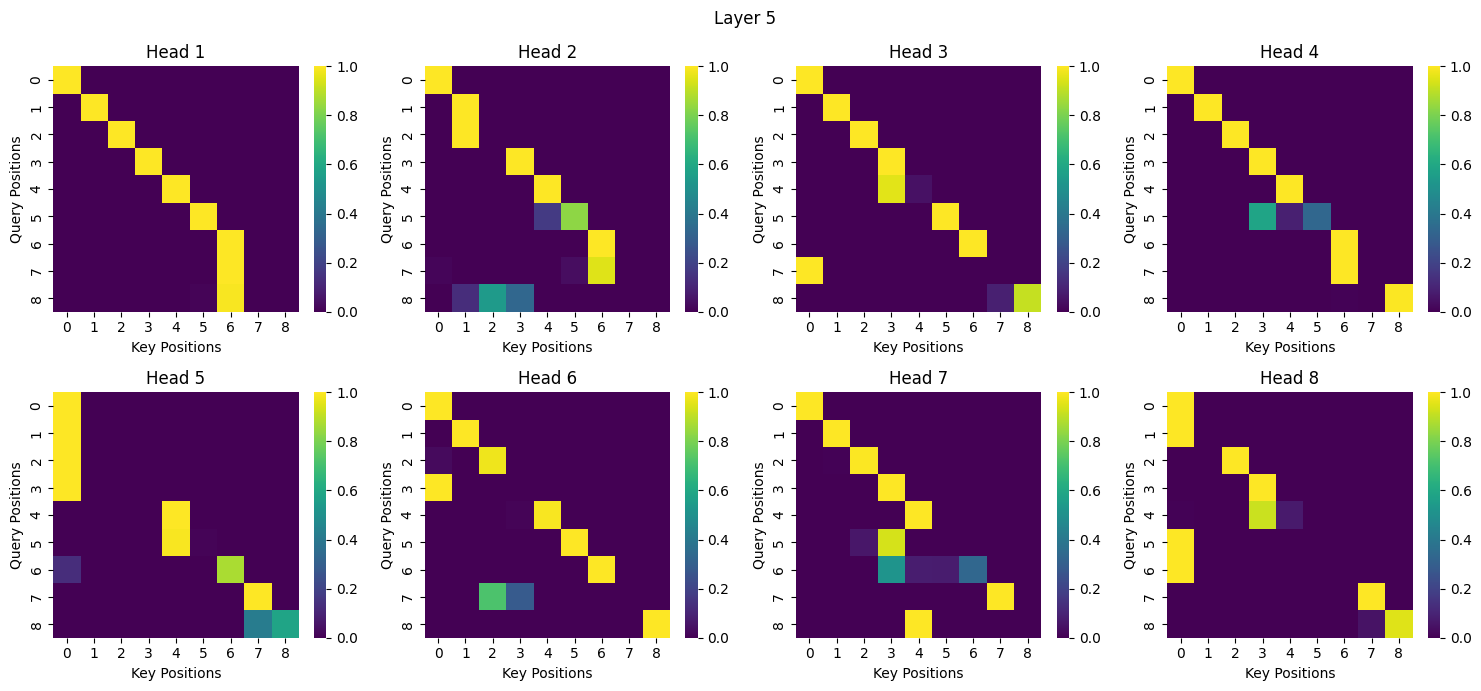

In [ ]:
for num, layer in enumerate(model.dec.dec_layers):
    att_maps = layer.mask_att.att_weights[0].detach().cpu().numpy()

    n_heads = att_maps.shape[0]

    fig, ax = plt.subplots(2, n_heads // 2, figsize=(15, 7))

    for i in range(n_heads):
        row = i // (n_heads // 2)  # Определяем строку
        col = i % (n_heads // 2)   # Определяем столбец
        sns.heatmap(att_maps[i],
                    ax=ax[row, col],
                    cmap="viridis")
        ax[row, col].set_title(f"Head {i + 1}")
        ax[row, col].set_xlabel("Key Positions")
        ax[row, col].set_ylabel("Query Positions")

    fig.suptitle(f'Layer {num}')
    plt.tight_layout()
    plt.show()

### $\text{Let`s show attention maps for cross-attention in decoder layers}$

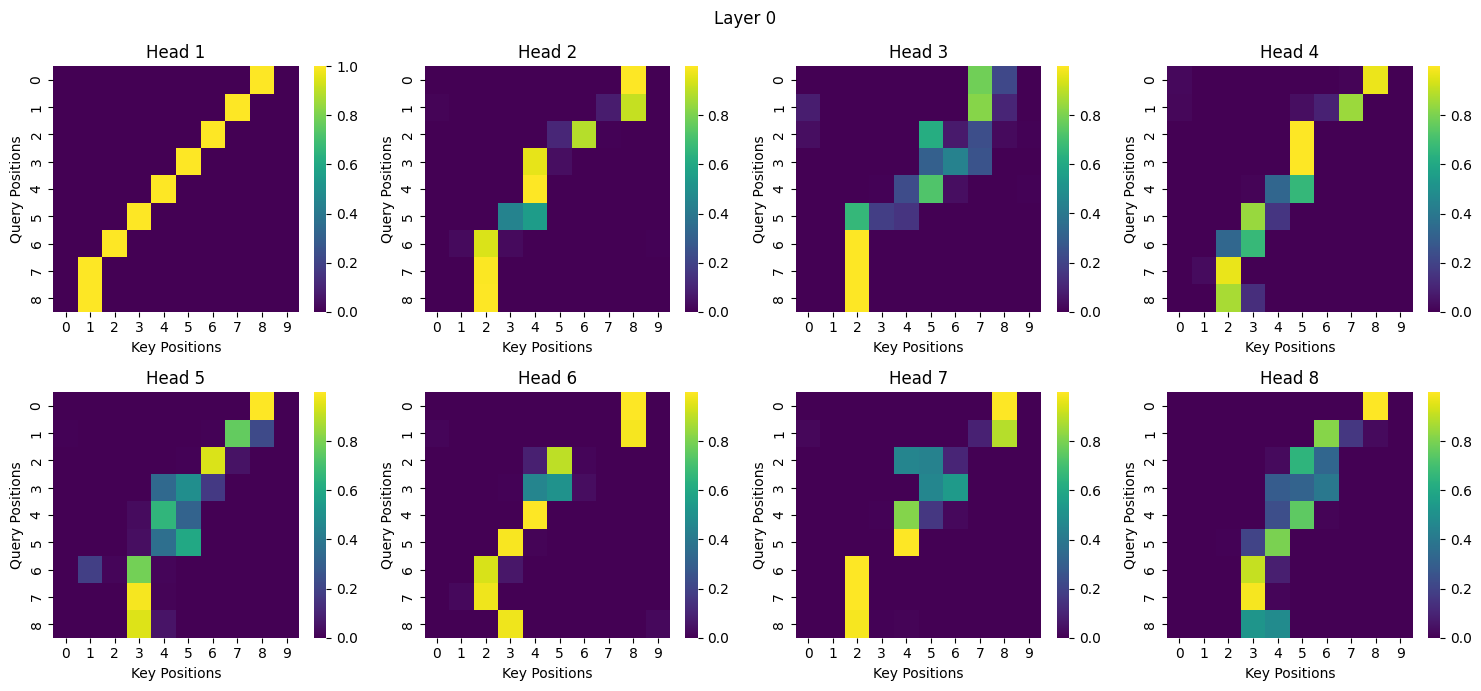

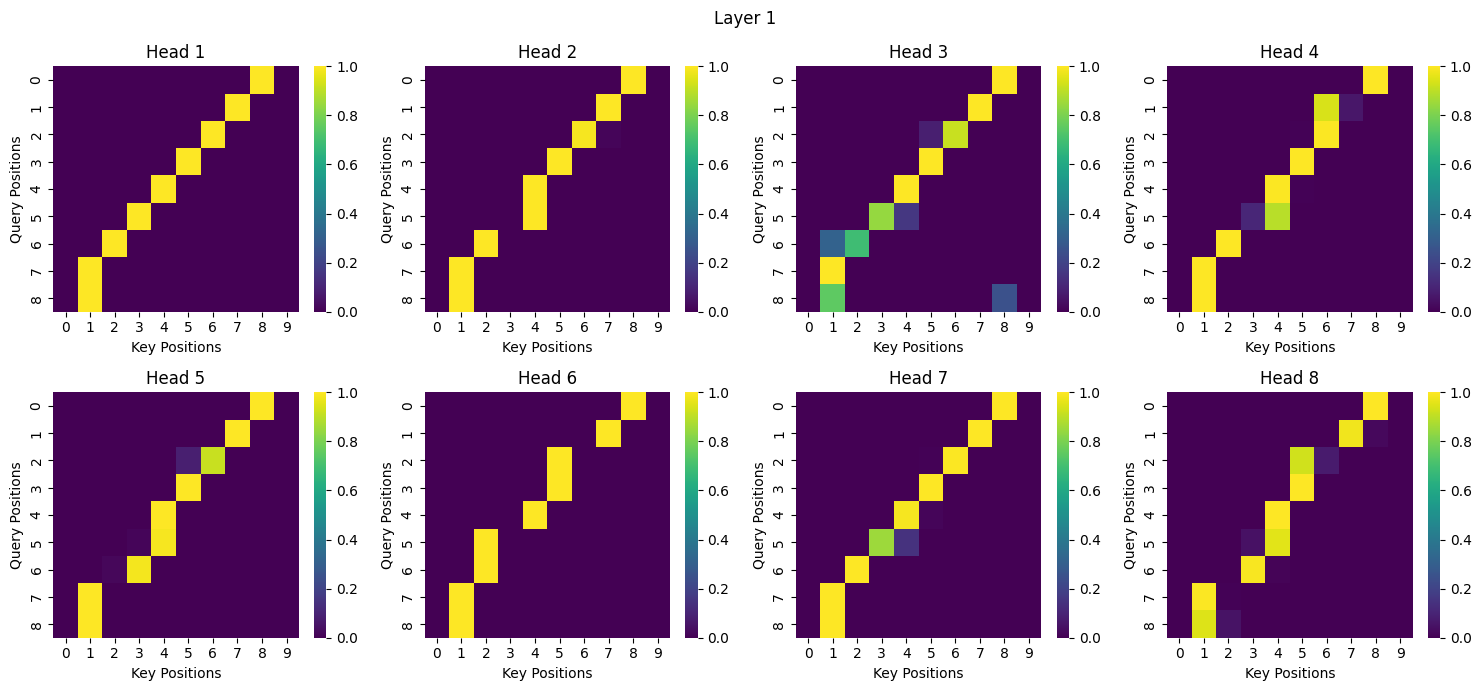

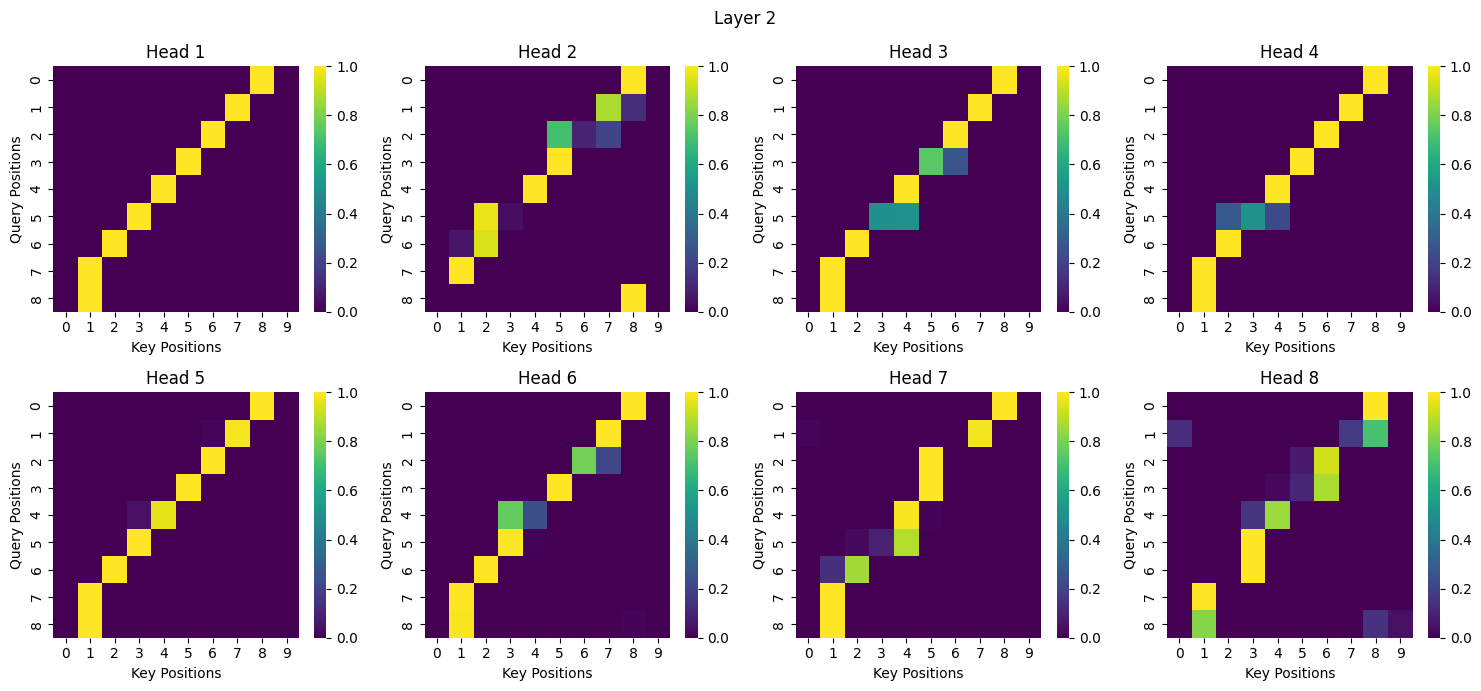

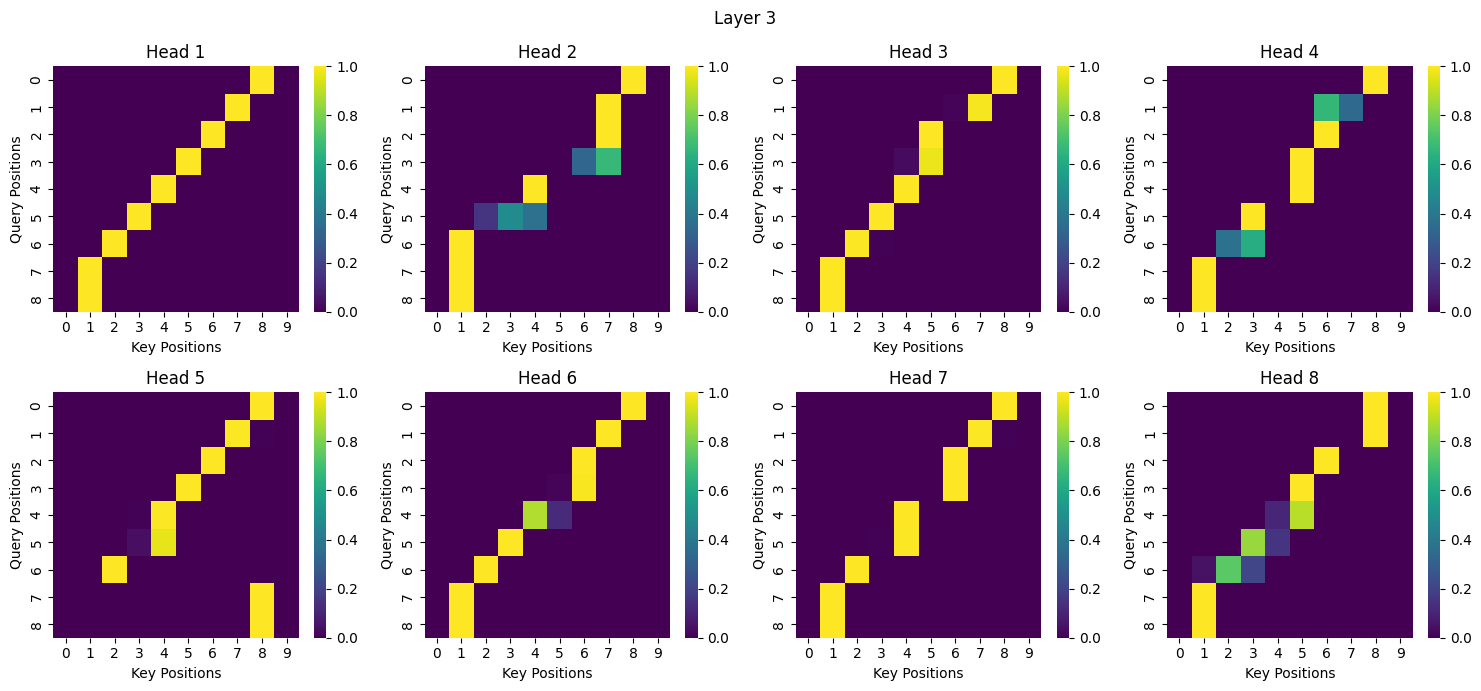

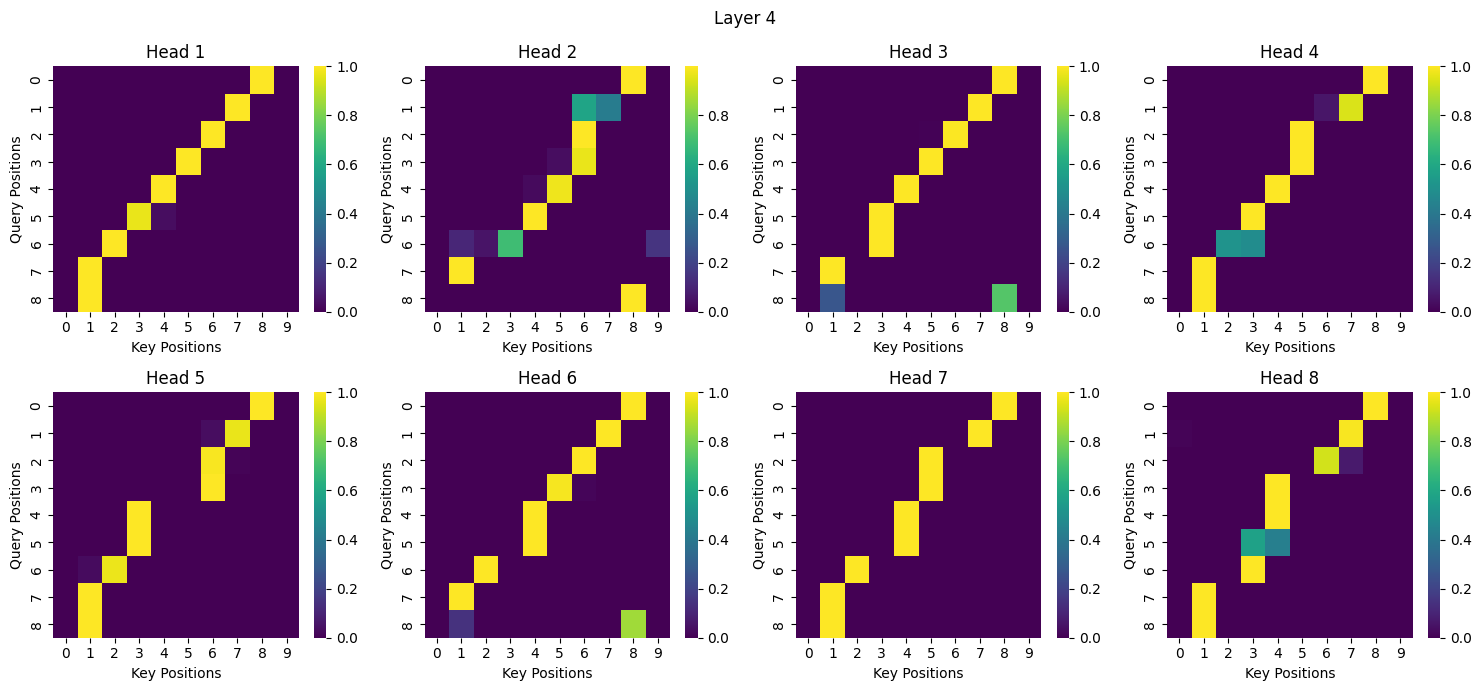

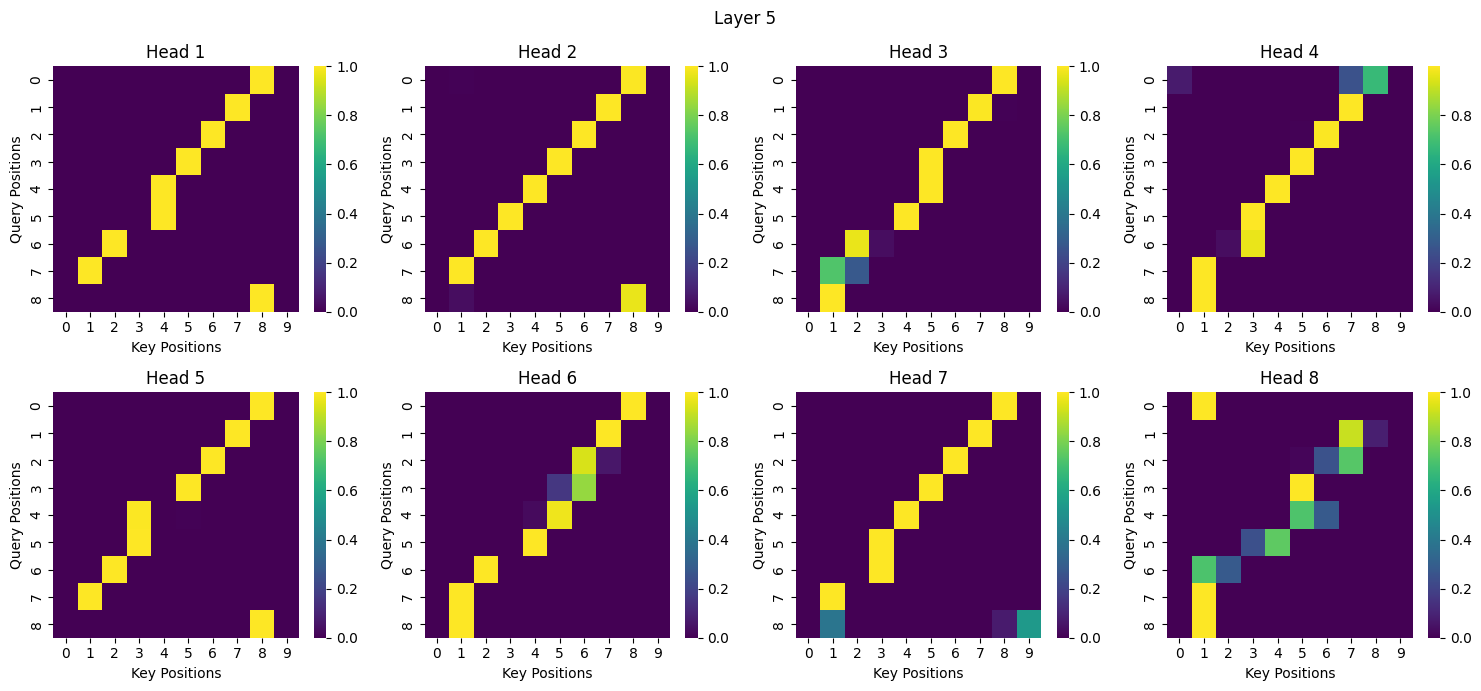

In [ ]:
for num, layer in enumerate(model.dec.dec_layers):
    att_maps = layer.cross_att.att_weights[0].detach().cpu().numpy()

    n_heads = att_maps.shape[0]

    fig, ax = plt.subplots(2, n_heads // 2, figsize=(15, 7))

    for i in range(n_heads):
        row = i // (n_heads // 2)  # Определяем строку
        col = i % (n_heads // 2)   # Определяем столбец
        sns.heatmap(att_maps[i],
                    ax=ax[row, col],
                    cmap="viridis")
        ax[row, col].set_title(f"Head {i + 1}")
        ax[row, col].set_xlabel("Key Positions")
        ax[row, col].set_ylabel("Query Positions")

    fig.suptitle(f'Layer {num}')
    plt.tight_layout()
    plt.show()